In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import numpy as np
import scipy as sp
import h5py
from scipy.interpolate import interp1d
from scipy.linalg import sqrtm, solve_sylvester, solve_lyapunov
import matplotlib.pyplot as plt
import sys
import pseudo
import os
import glob
import miscUtil
import ops
%matplotlib inline
#%matplotlib notebook

os.environ['DATA'] = os.environ['DATA186']
physDataDir = os.environ['DATA'] + 'phys/'
specDataDir = os.environ['DATA'] + 'spec/'
covDataDir = os.environ['DATA'] + 'cov/'
libDir = os.environ['LINLIB']
figureFolder = 'newFigures/'

# Using TWS mean for resolvent analysis
## First, a preliminary look at the mean velocity profiles

# Ignore all of this. These TWS are for Couette flow, not Poiseuille
I'm keeping the code for when I compute TWS.

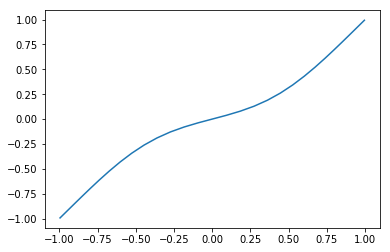

In [25]:
fName = '../data/tw1/tw1.asc'
Nx = 32; N = 33; Nz = 32
physFields = np.loadtxt(fName)
physFields = physFields.reshape((Nx,N+2,Nz,3))
# The ASCII file is ordered as {x, y, z, {u,v,w} }
U = np.mean(np.mean( physFields[:,:,:,0], axis=2), axis=0)[1:-1]
y,DM = pseudo.chebdif(N,2)
U = U + y
dU  = DM[:,:,0] @ U
d2U = DM[:,:,1] @ U

plt.plot(y, U)
plt.show()


In [26]:
U[0]/(1.-y[0]), U[-1]/(1.+y[-1])

(232.91129437110064, -232.91129438309471)

The mean velocity profile for TWS is not symmetric about the centerline. Rather, the TWS above is one of a pair of TWS that can be solutions. 

The asymmetry in itself is not a problem. It is the Reynolds number.

For TWS, $Re_\tau$ is as follows:
\begin{align}
        \rho \hat{u}_*^2 &= \rho \nu \frac{d\hat{U}}{d\hat{y}} \\
    \implies u_*^2 \hat{U}_{b}^2 &= \frac{\nu \hat{U}_{b}}{\hat{h}} \frac{dU}{dy} \\
    \implies u_*^2 &= \frac{1}{Re_{b}} \frac{dU}{dy}
\end{align}
where $u_*$ is the friction velocity, and all velocities are non-dimensionalized with the bulk velocity.     



Of course, because of the asymmetry, the mean strain-rate is different at the two walls. If I use the average of the two, that would make more sense. Either way, the difference is a factor less than 2, so it shouldn't matter too much. 

First, we need to calculate the bulk velocity. The velocity fields right now are not normalized by the bulk velocity, but the centerline velocity for laminar flow. 

The bulk velocity in terms of the centerline velocity for laminar is

In [27]:
w = pseudo.clencurt(N)
Ub = w @ U   # w includes a division by 2 (non-dimensional channel width)
print("Bulk velocity, normalized by laminar centerline is", Ub)


Bulk velocity, normalized by laminar centerline is 2.38390948145e-08


That's strange. The bulk velocity is very close to the laminar. Is that because the ''perturbations'' are too tiny? 

In [29]:
print("Bulk velocity of the travelling wave is ",w@(U- y))

Bulk velocity of the travelling wave is  2.38390948153e-08


This number is smaller than the accuracy of the solution, so I should think of it as being 0. 

This must be because of the way the computation is set up: to keep the bulk flow constant while the pressure gradient adapts. This makes sense. The pressure gradient indeed changes, because the shear stress at the wall is significantly larger. 



In [34]:
print("Average wall shear stress (and mean pressure gradient), normalized by laminar case is",
     0.25*((1.-U[0])/(1.-y[0]) + (1.+U[-1])/(1.+y[-1]))   )

Average wall shear stress (and mean pressure gradient), normalized by laminar case is 0.755010021215


That doesn't say much either. The numbers may look big here, but I did use a simple finite difference here to calculate the gradient. 

Let me see if it changes if I use a proper spectral derivative.

In [19]:
yFull, DMfull = pseudo.chebdif(N,2,walls=True)
# Include wall-node-entries for differentiation

D1Full = DMfull[:,:,0]
Ufull = np.concatenate(([0.], U, [0.]))
dUfull = D1Full @ Ufull

print("Average wall shear stress (and mean pressure gradient), normalized by laminar case is",
     0.25*(-dUfull[0] + dUfull[-1])   )

Average wall shear stress (and mean pressure gradient), normalized by laminar case is 0.999999997041


Fair enough. The average stress being the same as the laminar case isn't an artefact of the differentiation.

I wonder if this is true only for TW1. Let's look at TW2 and TW3 from the database.

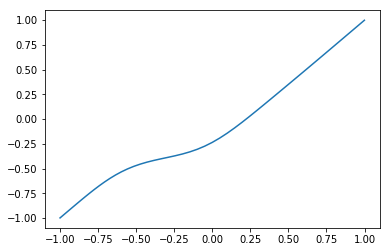

Bulk velocity, normalized by laminar centerline velocity is -0.0879005722245


ValueError: operands could not be broadcast together with shapes (65,) (63,) 

In [36]:
# TW2; Bulk velocity and mean shear stress
fName = '../data/tw2/tw2.asc'
Nx = 24; N = 63; Nz = 32
physFields = np.loadtxt(fName)
physFields = physFields.reshape((Nx,N+2,Nz,3))
# The ASCII file is ordered as {x, y, z, {u,v,w} }
U = np.mean(np.mean( physFields[:,:,:,0], axis=2), axis=0)[1:-1]
y,DM = pseudo.chebdif(N,2)
U = U + y
dU  = DM[:,:,0] @ U
d2U = DM[:,:,1] @ U

plt.plot(y, U)
plt.show()

w = pseudo.clencurt(N)
Ub = w @ U   # w includes a division by 2 (non-dimensional channel width)
print("Bulk velocity, normalized by laminar centerline velocity is", Ub)

yFull, DMfull = pseudo.chebdif(N,2,walls=True)
# Include wall-node-entries for differentiation

D1Full = DMfull[:,:,0]
Ufull = np.concatenate(([0.], U, [0.]))
dUfull = D1Full @ (Ufull - y)

print("Average wall shear stress (and mean pressure gradient), normalized by laminar case is",
     0.25*(-dUfull[0] + dUfull[-1])   )

Ah! So the computation imposes the mean pressure gradient, not bulk velocity. Turns out the solver is written to impose either conditions, but I suppose these solutions were computed for constant mean pressure gradient. 

It's just that TW1 is just low-drag. Let's have a look at TW3 too.

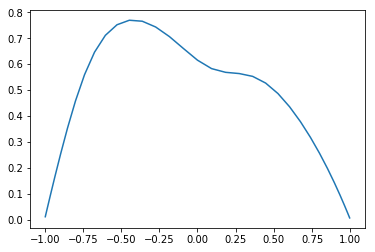

Bulk velocity, normalized by laminar centerline velocity is 0.513392669761
Average wall shear stress (and mean pressure gradient), normalized by laminar case is 0.999999849245


In [23]:
# TW3; Bulk velocity and mean shear stress
fName = '../data/tw3/tw3.asc'
Nx = 32; N = 33; Nz = 32
physFields = np.loadtxt(fName)
physFields = physFields.reshape((Nx,N+2,Nz,3))
# The ASCII file is ordered as {x, y, z, {u,v,w} }
U = np.mean(np.mean( physFields[:,:,:,0], axis=2), axis=0)[1:-1]
y,DM = pseudo.chebdif(N,2)
U = U + (1.-y**2)
dU  = DM[:,:,0] @ U
d2U = DM[:,:,1] @ U

plt.plot(y, U)
plt.show()

w = pseudo.clencurt(N)
Ub = w @ U   # w includes a division by 2 (non-dimensional channel width)
print("Bulk velocity, normalized by laminar centerline velocity is", Ub)

yFull, DMfull = pseudo.chebdif(N,2,walls=True)
# Include wall-node-entries for differentiation

D1Full = DMfull[:,:,0]
Ufull = np.concatenate(([0.], U, [0.]))
dUfull = D1Full @ Ufull

print("Average wall shear stress (and mean pressure gradient), normalized by laminar case is",
     0.25*(-dUfull[0] + dUfull[-1])   )

This one shows even lower bulk velocity than TW2. Good. So, all three solutions are at the same $Re_\tau$, which is the same as for the laminar case. This $Re_\tau$ isn't very small either. I can proceed with using these mean profiles for the resolvent analysis.

# TWS from Waleffe 
Exact coherent structures in Channel flow, JFM, 2001

(Solutions hosted on his website)



He computed lower and upper branch solutions for half-channels. 

The Reynolds number is, $Re_p$ = 1517.1, where
$$ Re_p := \bigg|\frac{dP}{dx}\bigg| \frac{h^3}{2\nu^2}, $$
and all the quantities on the RHS are dimensional. Actually, there's supposed to be a $P/\rho$ in there, but I guess Waleffe ignores $\rho$. I'll do the same. Well, no, I'll keep it first, and then say that it's 1.

From a long time ago, I showed that (for laminar flow)
$$ \frac{dP}{dx} \frac{h}{\rho U_{CL}^2 } = \frac{-2}{Re_{CL}};  2 Re_{CL} = Re^2_{\tau}; $$
The absolute value of the mean pressure gradient relates to the friction Reynolds number as
$$ \bigg|\frac{dP}{dx}\bigg|  = \frac{4}{Re^2_{\tau}} \frac{\rho U_{CL}^2 }{h}.   $$

Then, $Re_p$ relates to $Re_{CL}$ as (saying $\rho=1$)
$$ Re_p =  \frac{2}{Re_{CL}} \frac{ U_{CL}^2 }{h}  \frac{h^3}{2\nu^2} = Re_{CL}. $$
Cool, but not unexpected though, because $U_{CL}$ goes linearly with $dP/dx$. Both Reynolds numbers are proportional. I guess the factor 2 in the definition of $Re_p$ ensures they are equal. 

Anywho, this means that, 
$$Re^2_\tau = 2 Re_{CL} = 2 Re_p \approx 3030$$
$$\implies Re_\tau \approx 55.1$$

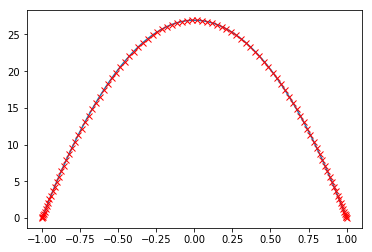

In [52]:
uAvg = np.loadtxt('/home/svadarevu/DNS/r55_80x48x96/outputdir/u_avg_it19100.dat')[3:-3]
yCC = miscUtil.nodesCellCenters(nCells=96)
plt.plot(yCC, uAvg)
plt.plot(yCC, (1. - yCC**2)*np.max(uAvg),'rx')
plt.show()

I tried to get a turbulent mean at $Re_\tau=55$ so that I can compare the resolvent modes from the upper branch TWS to those from the turbulent mean. I used a flowfield from $Re_\tau=590$ for initialization. Didn't happen. The flow decays to laminar as can be seen from the above plot. 

I suppose I can just use the Cess profile, for no reason, with some coefficients $\alpha$ and $\kappa$ that I got from curve-fitting for $Re_\tau=186$. Or I can continue the TWS for Waleffe to $Re_\tau=186$ using channelflow. We'll see. 

# Continuing Waleffe's upper branch solution
First thing is to figure out his formatting

<IPython.core.display.Javascript object>


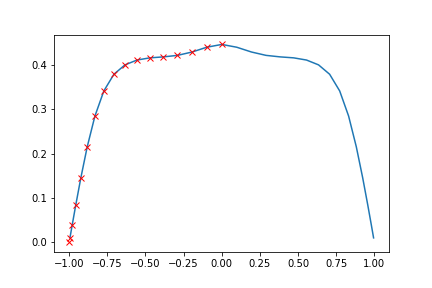

In [163]:
# Waleffe's data is only saved for 0 <= y <= -1. Reading this file
v1 = np.loadtxt('../waleffeTWS/Vy.dat')
eta1 = np.loadtxt('../waleffeTWS/Oy.dat')
yU1 = np.loadtxt('../waleffeTWS/yU.dat')
U1 = yU1[:,1]
v1 = v1.reshape((32,32,17),order='F')   # the dat files are fortran-ordered (first index changes fastest)
eta1 = eta1.reshape((32,32,17),order='F')
# Index axes are x,z,y (z is spanwise)

# Extend half-channel data to full channel
v = np.zeros((32,32,31))
v[:,:,15:] = v1[:,:,:-1]
v[:,:,:15] = -v[:,:,16:][:,:,::-1]
# v(x,z,-y) = -v(x,z,-y),  eta(x,z,-y) = eta(x,z,y), eta is the wall-normal vorticity
eta = np.zeros((32,32,31))
eta[:,:,15:] = eta1[:,:,:-1]
eta[:,:,:15] = eta[:,:,16:][:,:,::-1]
U = np.zeros(31)
U[15:] = U1[:-1]
U[:15] = U[16:][::-1]

y = pseudo.chebdif(31,1)[0]
vPhys = v
etaPhys = eta
del v, v1, eta, eta1, U1
plt.figure()
plt.plot(y, U)
plt.plot(yU1[:,0], yU1[:,1],'rx')
plt.show()

(31,) (32, 32, 31)


<IPython.core.display.Javascript object>


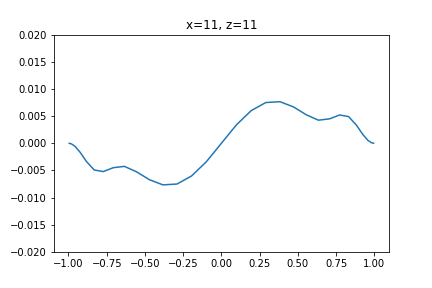

In [133]:
%matplotlib notebook
print(y.shape, vPhys.shape)
fig,axis = plt.subplots(1,1)
pl, = axis.plot(y, vPhys[0,0])
axis.set_ylim([-0.02, 0.02])
for x in range(0,12):
    for z in range(0,12):
        pl.set_ydata(vPhys[x,z])
        axis.set_title('x=%d, z=%d'%(x,z))
        fig.canvas.draw()
    

<IPython.core.display.Javascript object>


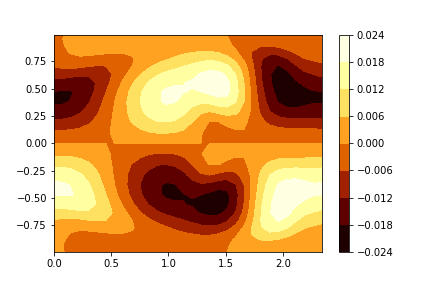

In [134]:
xArr = np.arange(0., 2.*np.pi, 2.*np.pi/32)
zArr = np.arange(0., 2.*np.pi/2.6, 2.*np.pi/2.6/32)
plt.figure()
plt.contourf( zArr, y, vPhys[5].T,cmap='afmhot')
plt.colorbar()
plt.show()

## Computing $u, w$ from $v,\eta$

By definition, $\eta = \partial_z u - \partial_x w$, and from continuity, $\partial_y v = -\partial_x u - \partial_z w$. So
$$ \partial_z \eta - \partial_{xy} v = (\partial_{xx} + \partial_{zz}) u .$$
and
$$ \partial_x \eta + \partial_{zy} v = -(\partial_{xx} + \partial_{zz}) w ,$$

These Poisson equations can be integrated with BCs $u=w=0$ at the walls. There's no need for integration though. In the Fourier domain, the Laplacian turns into a scalar factor for the coefficients. It's easier to solve it that way.


In [165]:
Nx = vPhys.shape[0]; Nz = vPhys.shape[1]; N = vPhys.shape[2]

a = 1.; b = 2.6 # Periodic box used by Waleffe
y, DM = pseudo.chebdif(31,2)
D1 = DM[:,:,0]; D2 = DM[:,:,1]

v   = np.fft.rfftn(vPhys, axes=(0,1))/Nx/Nz
eta = np.fft.rfftn(etaPhys, axes=(0,1))/Nx/Nz
# v and eta are the Fourier coefficients
lArr = np.arange(Nx); lArr[Nx//2+1:] -= Nx; lArr= lArr.reshape((Nx,1,1))
mArr = np.arange(Nz//2+1); mArr = mArr.reshape((1,Nz//2+1,1))

eta_x = 1.j*a*lArr*eta
eta_z = 1.j*b*mArr*eta
v_y = v @ D1.T
v_xy = 1.j*a*lArr*v_y
v_zy = 1.j*b*mArr*v_y

k2 = a**2 * lArr**2 + b**2 * mArr**2
k2[0,0,0] = 1.
# Because otherwise the denominator goes to zero below
# That's strictly not an issue, because I set the zeroth modes to 0 later
# But, setting m0 and l0 to be non-zero avoids warnings
u = -(eta_z - v_xy )/k2
w =  (eta_x + v_zy )/k2
u[0,0] = U
w[0,0] = 0.

uPhys = Nx*Nz*np.fft.irfftn(u, axes=(0,1))
wPhys = Nx*Nz*np.fft.irfftn(w, axes=(0,1))

Approximate phase-speed is, apparently, the mean-velocity at the first inflection point (minimum slope). This is easily calculated from the mean profile

<IPython.core.display.Javascript object>


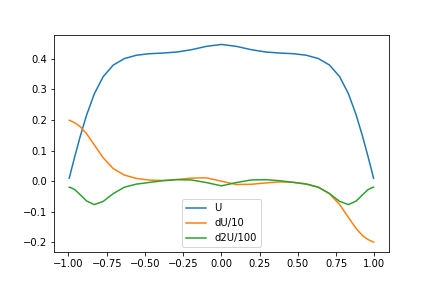

(3, 0.4881808272418805)

In [169]:
plt.figure()
plt.plot(y, U)
plt.plot(y, D1 @ U/10.)
plt.plot(y, D2 @ U/100.)
plt.legend(['U', 'dU/10', 'd2U/100'])
plt.show()

N = 31
d2U = D2@U
np.argmax(d2U[N//2:]), (d2U[N//2:])[np.argmax(d2U[N//2:])]

## Verify the NSE (for some phase-speed $c$ ) for the soln

In [ ]:
u_x = 1.j*a*lArr*u
v_x = 1.j*a*lArr*v
w_x = 1.j*a*lArr*w

u_y = u @ D1.T
v_y = v @ D1.T
w_y = w @ D1.T

u_z = 1.j*b*mArr*u
v_z = 1.j*b*mArr*v
w_z = 1.j*b*mArr*w

k2[0,0,0] = 0.   # I this to 1 earlier to avoid divide by zero
Lapl_u = u @ D2.T - k2 * u
Lapl_v = v @ D2.T - k2 * v
Lapl_w = w @ D2.T - k2 * w

u_t = 


<IPython.core.display.Javascript object>


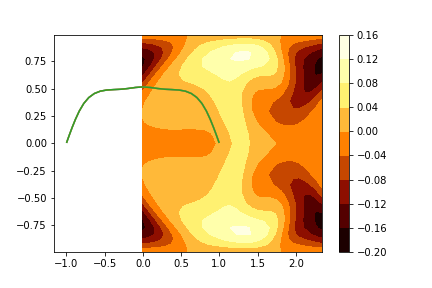

In [153]:
xArr = np.arange(0., 2.*np.pi/a, 2.*np.pi/a/Nx)
zArr = np.arange(0., 2.*np.pi/b, 2.*np.pi/b/Nz)
plt.figure()
plt.contourf( zArr, y, uPhys[5].T,cmap='afmhot')
plt.colorbar()
plt.show()

In [147]:
uLevels = 2.*np.arange(-0.5,0.501,0.025)
plt.figure()
plt.plot(Z[0,:,0], Y[0,:,0],'k')
plt.plot(Z[0,:,-1], Y[0,:,-1],'k')
plt.contourf(Z[0], Y[0], u[0], cmap=plt.get_cmap('RdBu_r'),levels = uLevels)
plt.colorbar()
plt.quiver(Z[0],Y[0], w[0],v[0],units='y',width=0.015,scale=0.3,scale_units='y',pivot='middle')
#print('Phase-shifted Eq1 at x0, with A=%.2g, fnorm=%.3g'%(0.01*k,fnorm))
print('Phase-shifted Eq2 at x0, with A=%.2g, fnorm=%.3g'%(0.01*k,fnorm))
plt.tight_layout()


0

In [149]:
plt.plot(y, u[])

dtype('int64')